In [1]:
# Basic imports, make sure they can import robustness
import torch as ch
from robustness.datasets import DATASETS
from robustness.tools.vis_tools import show_image_row
from robustness.tools import helpers
from robustness import model_utils, datasets
from torchvision.models import *
import torchvision.transforms as transforms
from robustness.tools.label_maps import CLASS_DICT

from tqdm import tqdm
import numpy as np
import PIL

%matplotlib inline

In [2]:
BATCH_SIZE = 5
NUM_WORKERS = 10

## Load dataset and model

In [3]:
def load_model(arch, dataset=None):
    if arch != 'robust':
        model = eval(arch)(pretrained=True).cuda()
        model.eval()
        pass
    else:
        model_kwargs = {
            'arch': 'resnet50',
            'dataset': dataset,
            'resume_path': f'./models/RestrictedImageNet.pt'
        }

        model, _ = model_utils.make_and_restore_model(**model_kwargs)
        model.eval()
        model = model.module.model
    return model

def load_dataset(dataset, data_path='/scratch/engstrom_scratch/imagenet'):
    ds = DATASETS[dataset](data_path)
    _, loader = ds.make_loaders(NUM_WORKERS, BATCH_SIZE)
    norm = helpers.InputNormalize(ds.mean, ds.std)
    return ds, loader, norm

In [4]:
imagenet_ds, in_loader, normalization_function = load_dataset('imagenet')
CD_in = CLASS_DICT['ImageNet']
std_model = load_model('resnet18')

==> Preparing dataset imagenet..


## Helpers

In [5]:
def forward_pass(mod, im):
    im_norm = normalization_function(im)
    op = mod(im_norm.cuda())
    return op

def get_gradient(mod, im, targ, custom_loss=None):
    
    def compute_loss(inp, target):
        if custom_loss is None:
            output = forward_pass(mod, inp)
            return ch.nn.CrossEntropyLoss()(output, target.cuda())
        else:
            return custom_loss(mod, inp, target.cuda())
        
    x = im.clone().detach().requires_grad_(True)
    loss = compute_loss(x, targ)
    grad, = ch.autograd.grad(loss, [x])
    return grad.clone(), loss.detach().item()

In [6]:
def vis_tensor(t):
    mt = ch.mean(t, dim=[2, 3], keepdim=True).expand_as(t)
    st = ch.std(t, dim=[2, 3], keepdim=True).expand_as(t)
    return ch.clamp((t - mt) / (2 * st) + 0.5, 0, 1) 

def smooth_grad(mod, im, targ, Nsamples, stdev, custom_loss=None):
    total_gradients = 0
    it = tqdm(enumerate(range(Nsamples)), total=Nsamples)
    for _, n in it:
        noise = ch.tensor(np.random.normal(0, stdev, im.shape), dtype=im.dtype)
        noised_im = im + noise
        grad, _ = get_gradient(mod, noised_im, targ, custom_loss=custom_loss)
        total_gradients += grad

    return total_gradients / Nsamples

In [7]:
def create_l2_adv_examples(mod, im, targ, step_size, Nsteps,
                           custom_loss=None, normalize=True, 
                           targeted=True, eps=None):
    
    if custom_loss is None:
        loss_fn = ch.nn.CrossEntropyLoss()
    else:
        loss_fn = custom_loss 
        
    sign = -1 if targeted else 1
        
    it = tqdm(enumerate(range(Nsteps)), total=Nsteps)
    x = im.detach()
    l = len(x.shape) - 1
    
    for _, i in it:    
        x = x.clone().detach().requires_grad_(True)
        g, loss = get_gradient(mod, x, targ, custom_loss=custom_loss)
        it.set_description(f'Loss: {loss}')
        g *= sign
        with ch.no_grad():
            if normalize:
                g_norm = ch.norm(g.view(g.shape[0], -1), dim=1).view(-1, *([1]*l))
                scaled_g = g / (g_norm + 1e-10)
            else: 
                scaled_g = g / 1
            
            x += scaled_g * step_size
            if eps is not None:
                diff = x - im
                diff = diff.renorm(p=2, dim=0, maxnorm=eps)
                x = im + diff
            x = ch.clamp(x, 0, 1)
    return x

## Evaluate accuracy (optional)

In [8]:
if False: # Use only if dataloader is complete imagenet
    correct_cnt, total = 0, 0
    it = tqdm(enumerate(in_loader), total=len(in_loader))
    for itidx, (im, targ) in it:
        with ch.no_grad():
            op = forward_pass(std_model, im)
            pred = op.argmax(dim=1)
            correct = targ.cuda().eq(pred)

            correct_cnt += np.sum(correct.cpu().numpy())
            total += len(targ)
            it.set_description(f"Accuracy: {100 * correct_cnt/total:.2f}%")

## Sensitivity Analysis

In [9]:
_, (img, targ) = next(enumerate(in_loader))

### Visualize gradient

In [10]:
grad, _ = get_gradient(std_model, img, targ)

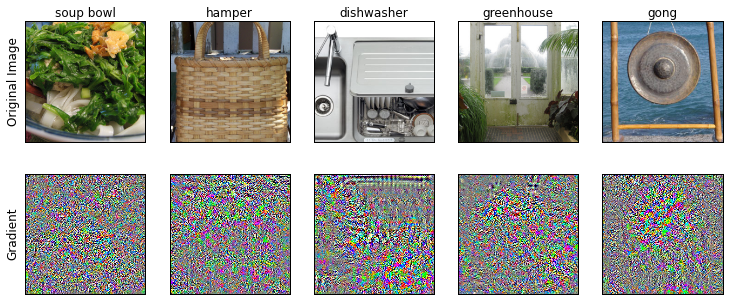

In [11]:
show_image_row([img, vis_tensor(grad)],
              ["Original Image", "Gradient"],
              tlist=[[CD_in[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

### Visualize SmoothGrad

In [12]:
sgrad = smooth_grad(std_model, img, targ, 100, 0.3)

100%|██████████| 100/100 [00:08<00:00, 11.35it/s]


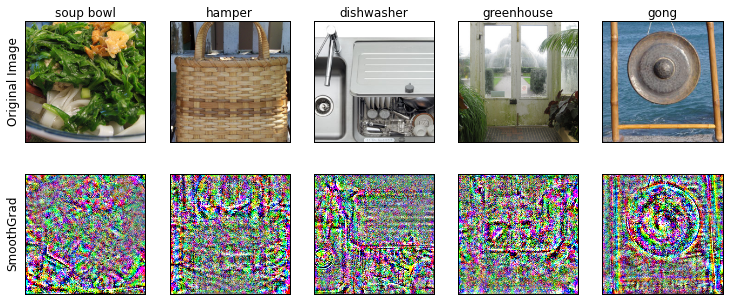

In [13]:
show_image_row([img, vis_tensor(sgrad)],
              ["Original Image", "SmoothGrad"],
               tlist=[[CD_in[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

## Adversarial examples

In [14]:
targ_class = 3 * ch.ones_like(targ)
adv_ex = create_l2_adv_examples(std_model, img, targ_class, 0.5, 20, 
                                targeted=True, eps=1.5)
with ch.no_grad():
    pred_label = forward_pass(std_model, adv_ex).argmax(dim=1)

Loss: 0.0007289886707440019: 100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


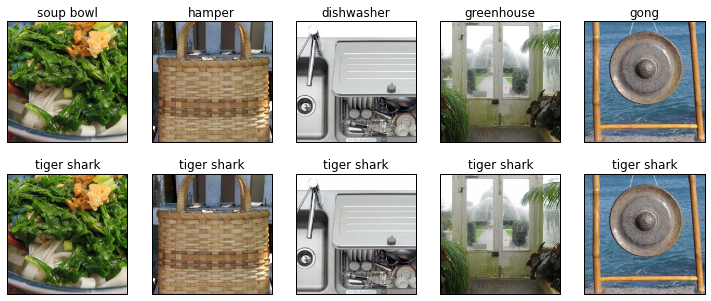

In [15]:
show_image_row([img, adv_ex], 
               tlist=[[CD_in[int(t)].split(',')[0] for t in label] for label in [targ, pred_label]])

## Robustness as a prior

### Load dataset and model (model is trained on a subset of ImageNet)

In [16]:
restricted_imagenet_ds, rin_loader, normalization_function = load_dataset('restricted_imagenet')
CD_rin = CLASS_DICT['RestrictedImageNet']

robust_model = load_model('robust', restricted_imagenet_ds)

==> Preparing dataset restricted_imagenet..
=> loading checkpoint './models/RestrictedImageNet.pt'
=> loaded checkpoint './models/RestrictedImageNet.pt' (epoch 61)


### Visualize gradient

In [17]:
_, (img, targ) = next(enumerate(rin_loader))

In [18]:
grad_rob, _ = get_gradient(robust_model, img, targ)

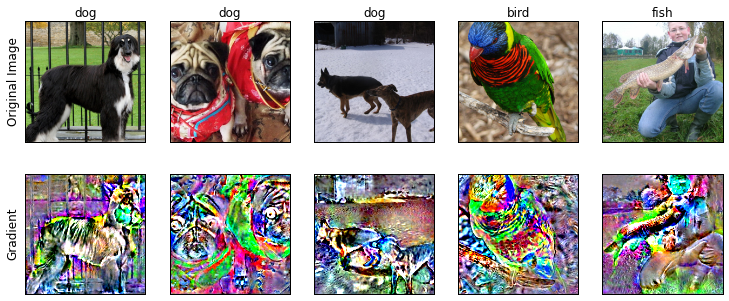

In [19]:
show_image_row([img, vis_tensor(grad_rob)],
              ["Original Image", "Gradient"],
              tlist=[[CD_rin[int(t)].split(',')[0] for t in targ],
                     ["" for _ in targ]])

### Adversarial Example

In [20]:
targ_class = 3 * ch.ones_like(targ)
adv_ex = create_l2_adv_examples(robust_model, img, targ_class, 0.5, 20, 
                                targeted=True, eps=1.5)
with ch.no_grad():
    pred_label = forward_pass(robust_model, adv_ex).argmax(dim=1)

Loss: 13.437993049621582: 100%|██████████| 20/20 [00:01<00:00, 14.80it/s]


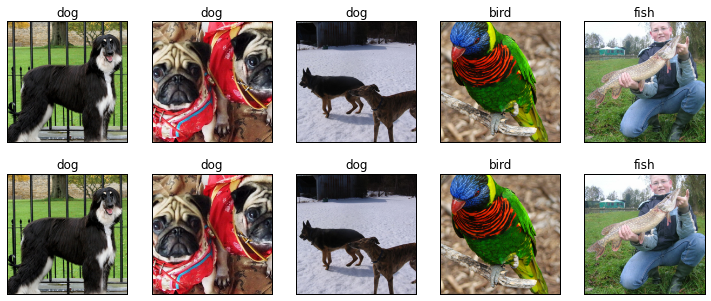

In [21]:
show_image_row([img, adv_ex], 
               tlist=[[CD_rin[int(t)].split(',')[0] for t in label] for label in [targ, pred_label]])

### Gradients induce semantically meaningful changes in input

In [22]:
targ_class = 5 * ch.ones_like(targ)
im_targ = create_l2_adv_examples(robust_model, img, targ_class, 5, 20, 
                                custom_loss=None, normalize=True)

Loss: 0.0: 100%|██████████| 20/20 [00:01<00:00, 14.93it/s]                   


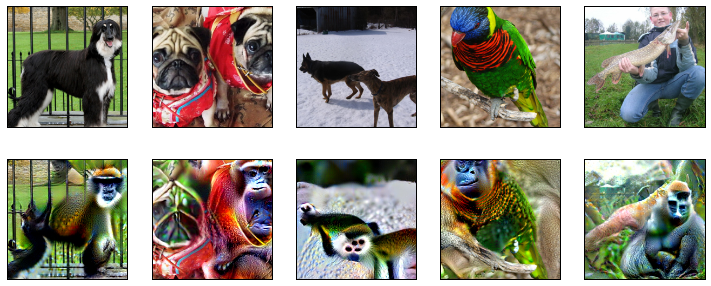

In [23]:
show_image_row([img, im_targ])

### Feature Visualization

In [24]:
def get_feature_representation(mod, im):
    feature_rep = ch.nn.Sequential(*list(mod.children())[:-1])
    im_norm = normalization_function(im.cpu()).cuda()
    return feature_rep(im_norm)[:, :, 0, 0]

def feature_maximization_loss(mod, im, targ):
    fr = get_feature_representation(mod, im)
    loss = ch.mean(ch.gather(fr, 1, targ[:, None]))
    return loss

In [25]:
targ_class = 700 * ch.ones_like(targ)
im_f = create_l2_adv_examples(robust_model, img, targ_class, 5, 20, 
                                custom_loss=feature_maximization_loss, 
                                targeted=False, normalize=True)

Loss: 1.9317506551742554: 100%|██████████| 20/20 [00:01<00:00, 14.74it/s]


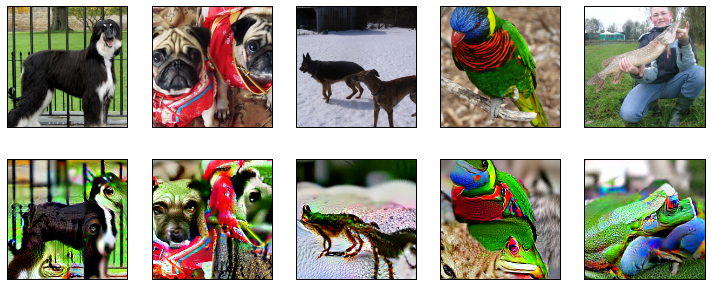

In [26]:
show_image_row([img, im_f])

#### Try the same for a standard model

In [27]:
_, (img, targ) = next(enumerate(in_loader))

targ_class = 100 * ch.ones_like(targ)
im_f = create_l2_adv_examples(std_model, img, targ_class, 5, 20, 
                                custom_loss=feature_maximization_loss, 
                                targeted=False, normalize=True)

Loss: 47.86199951171875: 100%|██████████| 20/20 [00:00<00:00, 34.34it/s] 


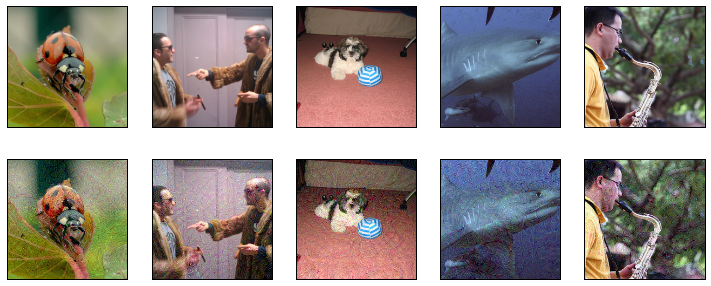

In [28]:
show_image_row([img, im_f])